In [68]:
import numpy,pandas,datetime,sklearn,s_dbw
import matplotlib,matplotlib.pyplot
import scanpy
scanpy.settings.verbosity=5

# 1. Reading data

In [2]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')
adata=idata.transpose()
print(adata)
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-05-07 09:35:14
AnnData object with n_obs × n_vars = 3477 × 22662 
2019-05-07 09:35:23


# 2. Preprocessing

    normalizing by total count per cell
        finished (0:00:01.37): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


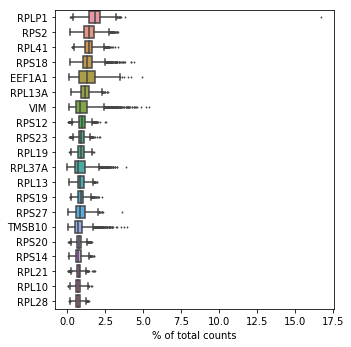

In [3]:
scanpy.pl.highest_expr_genes(adata,n_top=20)

In [4]:
scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)
print(adata)

filtered out 10557 genes that are detected in less than 3 cells
AnnData object with n_obs × n_vars = 3477 × 12105 
    obs: 'n_genes'
    var: 'n_cells'


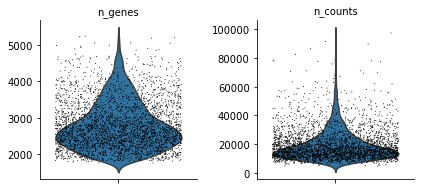

In [5]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
scanpy.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

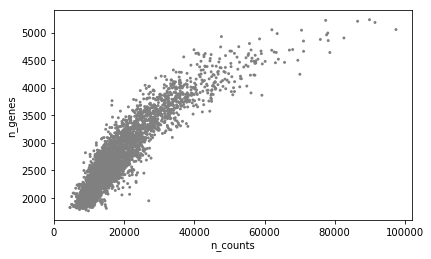

In [6]:
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [7]:
scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

    normalizing by total count per cell
        finished (0:00:00.40): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [8]:
adata.raw = adata

    extracting highly variable genes
        finished (0:00:00.91)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


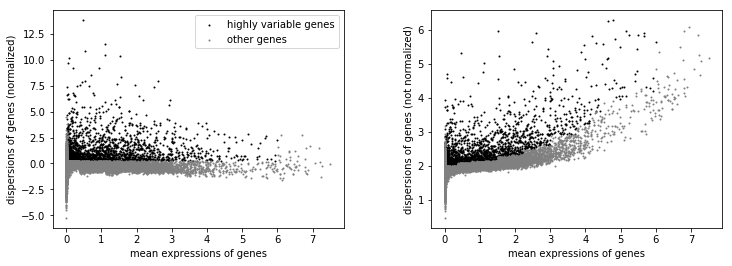

View of AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [9]:
#scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=5.5,min_disp=0.75) # 1,273
#scanpy.pp.highly_variable_genes(adata,min_mean=0.01,max_mean=6,min_disp=0.5) # 1,889
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
#scanpy.pp.highly_variable_genes(adata,min_mean=0,max_mean=8,min_disp=-5) # 12,104
scanpy.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
print(adata)

In [10]:
adata = adata[:, adata.var['highly_variable']]
print(adata)

View of AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [11]:
scanpy.pp.regress_out(adata, ['n_counts'])
scanpy.pp.scale(adata, max_value=10)
print(adata)

regressing out ['n_counts']
    finished (0:00:08.41)
    ... clipping at max_value 10
AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


# 3. Visualization

In [12]:
cellIDs=adata.obs_names.tolist()

dayLabels=[]; uDayLabels=[]
for cellID in cellIDs:
    broken=cellID.split('_M397.')
    dayLabel=broken[1]
    dayLabels.append(dayLabel)
    if dayLabel not in uDayLabels:
        uDayLabels.append(dayLabel) 
print(uDayLabels)
adata.obs['dayLabel']=dayLabels

['control', 'day3', 'day6', 'day13', 'day17', 'day24']


## 3.1. PCA

In [13]:
scanpy.tl.pca(adata, svd_solver='arpack')

    computing PCA with n_comps = 50
        finished (0:00:01.70)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


... storing 'dayLabel' as categorical


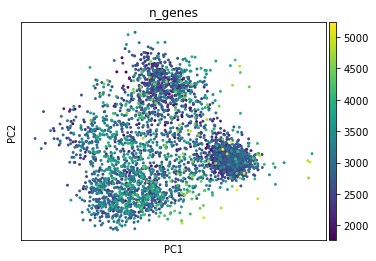

In [14]:
scanpy.pl.pca(adata, color='n_genes')

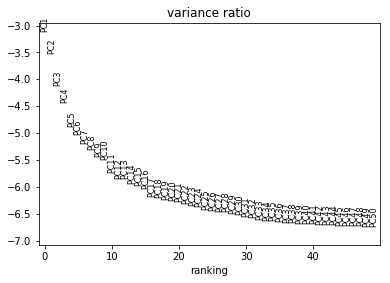

In [15]:
scanpy.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [16]:
#adata.write(resultsFile)
print(adata)

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'dayLabel'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


## 3.2. UMAP

In [60]:
nei=15
scanpy.pp.neighbors(adata,n_neighbors=nei,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)

In [64]:
test=adata.obs['louvain'].tolist()
print(len(test))
adata.obsm['X_umap']

3477


array([[-3.46830844,  2.0711075 ],
       [-2.89655026,  3.56437741],
       [-3.49644312,  2.59018548],
       ...,
       [-2.14149102,  1.00980983],
       [-0.02115002,  1.04338896],
       [-0.34783184, -1.6877559 ]])

In [66]:
categories=adata.obs['louvain'].cat.categories.tolist()
    
ranks=[sum(adata.obs['louvain'].values == str(label)) for label in categories]
standardDeviation=numpy.std(ranks)
accDev=numpy.sum([numpy.abs(rank-int(numpy.mean(ranks))) for rank in ranks])

# goodness of partition
positions=adata.obsm['X_umap']
categories=adata.obs['louvain'].tolist()
numericCategories=[float(element) for element in categories]

SS=sklearn.metrics.silhouette_score(positions,numericCategories,metric='euclidean')
CHI=sklearn.metrics.calinski_harabaz_score(positions,numericCategories)
VI=s_dbw.S_Dbw(positions,numericCategories)

print(SS,CHI,score)

0.38336015248768496 4013.0998706644395 0.3088169677767967


In [ ]:
def stateFinder(nei):
    
    scanpy.pp.neighbors(adata,n_neighbors=nei,n_pcs=50)
    scanpy.tl.umap(adata)
    scanpy.tl.louvain(adata)
    
    positions=adata.obsm['X_umap']
    categories=adata.obs['louvain'].tolist()
    numericCategories=[float(element) for element in categories]
    uniqueCategories=list(set(numericCategories))

    # goodness of partition
    SS=sklearn.metrics.silhouette_score(positions,numericCategories,metric='euclidean')
    CHI=sklearn.metrics.calinski_harabaz_score(positions,numericCategories)
    VI=s_dbw.S_Dbw(positions,numericCategories)
    
    # store results
    meanResult=(nei,meanK,meanSS,meanCHI,meanVI)
    stdResult=(nei,stdK,stdSS,stdCHI,stdVI)

    #result.append([meanResult,stdResult])
    return 'done'

In [87]:
# dont forget to bootstrap: select the same data set randomly, then evaluate clusters that 
# and to use 3D
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

scanpy.settings.verbosity=0
numberOfThreads=4
bootstrapRank=10

fine=numpy.arange(5,31,1)
coarse=numpy.arange(35,55,5)
veryCoarse=numpy.arange(75,225,25)
joined=numpy.concatenate((fine,coarse))
numberOfNeighbors=numpy.concatenate((joined,veryCoarse))
numberOfNeighbors=numpy.arange(10,30+10,10)
print(numberOfNeighbors)

hydra=multiprocessing.pool.Pool(numberOfThreads)

results=hydra.map(stateFinder,numberOfNeighbors)





for nei in numberOfNeighbors:
    
    
    
scanpy.settings.verbosity=5
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-05-07 11:49:50
(5, 16, 0.29741294071515256, 3273.3256040131296, 0.3135706330155525)
(6, 12, 0.3783047673185807, 4214.908237216605, 0.2979946362482408)
(7, 12, 0.3724556153424996, 4185.61546817504, 0.30582454788559404)
(8, 11, 0.3921364494001208, 3856.8598109090767, 0.3467213832415545)
(9, 11, 0.4068113869151443, 4558.136670998212, 0.3567973505413444)
(10, 11, 0.37101567847909145, 3633.8203696263818, 0.35749285620909677)
(11, 11, 0.39715137559874825, 4016.104931200809, 0.4400236425719032)
(12, 10, 0.39411256193493516, 4148.712521233796, 0.30283254595819753)
(13, 10, 0.3974311154141124, 3975.7521268918126, 0.39464968484256074)
(14, 10, 0.35379636024660344, 3656.6664044074228, 0.32442704891092555)
(15, 10, 0.38336015248768496, 4013.0998706644395, 0.3088169677767967)
(16, 9, 0.4071769525496882, 4819.657109955393, 0.3177999160912824)
(17, 9, 0.3761591315554502, 4110.115498455094, 0.30128853189401605)
(18, 10, 0.3939885633112354, 4074.398566604078, 0.3544336645493932)
(19, 9, 0.42401683

(2, 50.5)

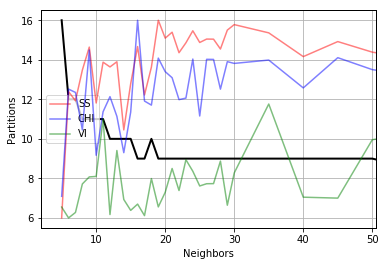

In [89]:
a=[result[0] for result in results]
b=[result[1] for result in results]
c=[result[2] for result in results]
d=[result[3] for result in results]
e=[result[4] for result in results]

fig, ax1 = matplotlib.pyplot.subplots()
line1=ax1.plot(a,b,'-',color='black',lw=2)


ax2=ax1.twinx()
ax2.set_yticks([])
line2=ax2.plot(a,c,'-',color='red',label='SS',alpha=0.5)

ax3=ax1.twinx()
ax3.set_yticks([])
line3=ax3.plot(a,d,'-',color='blue',label='CHI',alpha=0.5)

ax4=ax1.twinx()
ax4.set_yticks([])
line4=ax4.plot(a,e,'-',color='green',label='VI',alpha=0.5)


lns = line2+line3+line4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc=6)

ax1.set_ylabel('Partitions')
ax1.set_xlabel('Neighbors')
ax1.grid()
ax1.set_xlim([2,50.5])

## Potting

In [ ]:
scanpy.pl.umap(adata, color=['dayLabel'],palette=['black','blue','green','orange','red','magenta'],alpha=0.5,save='dayLabels.genes.pdf')

In [ ]:
scanpy.pl.umap(adata, color=['louvain'],palette='Set3',save='louvain.genes.pdf')

In [ ]:
dayColors=['grey','blue','green','orange','red','magenta']
positions=adata.obsm['X_umap']
accumulatedDays=[]
for dayLabel in uDayLabels:
    
    accumulatedDays.append(dayLabel)
    tag='.'.join(accumulatedDays)
    
    xpos=[]; ypos=[]; myColors=[]
    for i in range(len(adata.obs['dayLabel'])):
        if adata.obs['dayLabel'][i] in accumulatedDays:
            xpos.append(positions[i,0])
            ypos.append(positions[i,1])
            myColors.append(dayColors[accumulatedDays.index(adata.obs['dayLabel'][i])])
            #myColors.append(adata.obs['louvain'][i])
    
    print(tag,accumulatedDays,len(xpos))
    matplotlib.pyplot.scatter(xpos,ypos,color=myColors,alpha=1/3,edgecolors='none')
    
    matplotlib.pyplot.xlim([-7.5,10])
    matplotlib.pyplot.ylim([-10,7])
    #matplotlib.pyplot.xlabel('umap1')
    #matplotlib.pyplot.ylabel('umap2')
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])
    #matplotlib.pyplot.grid(color='k', linestyle=':', linewidth=1,alpha=1/3,zorder=0)
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('figures.perDay.genes/{}.pdf'.format(tag))
    matplotlib.pyplot.clf()

## Highlighted by day and Louvain membership

In [ ]:
LouvainColors=adata.uns['louvain_colors']
LouvainMemberships=adata.obs['louvain'].tolist()
positions=adata.obsm['X_umap']
accumulatedDays=[]

for dayLabel in uDayLabels:
    
    accumulatedDays.append(dayLabel)
    tag='.'.join(accumulatedDays)
    
    xpos=[]; ypos=[]; myColors=[]
    for i in range(len(adata.obs['dayLabel'])):
        if adata.obs['dayLabel'][i] in accumulatedDays:
            xpos.append(positions[i,0])
            ypos.append(positions[i,1])
            myColors.append(LouvainColors[int(LouvainMemberships[i])])
    
    print(tag,accumulatedDays,len(xpos))
    matplotlib.pyplot.scatter(xpos,ypos,color=myColors,alpha=3/4,edgecolors='none')
    
    matplotlib.pyplot.xlim([-7.5,10])
    matplotlib.pyplot.ylim([-10,7])
    #matplotlib.pyplot.xlabel('umap1')
    #matplotlib.pyplot.ylabel('umap2')
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])
    #matplotlib.pyplot.grid(color='k', linestyle=':', linewidth=1,alpha=1/3,zorder=0)
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('figures.perDay.genes/{}.perDay.LouvainMemberships.pdf'.format(tag))
    matplotlib.pyplot.clf()

In [ ]:
##### non cumulative
LouvainColors=adata.uns['louvain_colors']
LouvainMemberships=adata.obs['louvain'].tolist()
positions=adata.obsm['X_umap']
accumulatedDays=[]
worldColors={}

for dayLabel in uDayLabels:
    
    accumulatedDays=[]
    accumulatedDays.append(dayLabel)
    tag='.'.join(accumulatedDays)
    worldColors[dayLabel]=[]
    
    xpos=[]; ypos=[]; myColors=[]
    for i in range(len(adata.obs['dayLabel'])):
        if adata.obs['dayLabel'][i] in accumulatedDays:
            xpos.append(positions[i,0])
            ypos.append(positions[i,1])
            myColors.append(LouvainColors[int(LouvainMemberships[i])])
            worldColors[dayLabel].append(LouvainColors[int(LouvainMemberships[i])])
    
    print(tag,accumulatedDays,len(xpos))
    matplotlib.pyplot.scatter(xpos,ypos,color=myColors,alpha=3/4,edgecolors='none')
    
    matplotlib.pyplot.xlim([-7.5,10])
    matplotlib.pyplot.ylim([-10,7])
    #matplotlib.pyplot.xlabel('umap1')
    #matplotlib.pyplot.ylabel('umap2')
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])
    #matplotlib.pyplot.grid(color='k', linestyle=':', linewidth=1,alpha=1/3,zorder=0)
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('figures.perDay.genes/{}.perDay.non.cumulative.LouvainMemberships.pdf'.format(tag))
    matplotlib.pyplot.clf()

f = open("worldColors.txt","w")
f.write( str(worldColors) )
f.close()

In [ ]:
adata.write(resultsFile)

# 4. Marker genes

In [ ]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='t-test')
scanpy.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pandas.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
print(pandas.DataFrame(adata.uns['rank_genes_groups']['names']).head(5))
adata.write(resultsFile)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['0'], n_genes =20)

In [ ]:
scanpy.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
adata = scanpy.read(resultsFile)
scanpy.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
scanpy.pl.violin(adata, ['RPS4X', 'SOX10', 'TYMS'], groupby='louvain')

In [ ]:
markerGenes=['RPS4X','SOX10','TYMS','SPARC','RPL31','UQCRB','S100A4','TPM1','RPL37A','ATAD2','CDKN3']
ax = scanpy.pl.dotplot(adata, markerGenes, groupby='louvain')

In [ ]:
ax = scanpy.pl.stacked_violin(adata, markerGenes, groupby='louvain', rotation=90)

In [ ]:
print(adata)

In [ ]:
adata.write_csvs(resultsFile[:-5],skip_data=False)